# Config-Header

In [1]:

import pandas as pd
import seaborn as sns
from pandas import read_csv

import config
import features.weather_config as wc
import features.weather_features
import features.weather_features as wf
from data_loader import load_weather_data

String Constants

In [2]:
TEMP_C = 'Temperature (°C)'

Load Main Weatherdata

In [3]:
weather_data_raw = load_weather_data()

Load Complementary Weatherdata

In [4]:
weather_data_new_rows = read_csv('../gitData/weather_data_new_rows.csv')

 Merge Weatherdata

In [5]:
weather_data_raw = pd.concat([weather_data_raw, weather_data_new_rows])

# EDA  weather_data

## EDA general

In [6]:
weather_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5334 entries, 0 to 158
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    5334 non-null   object 
 1   temp         5334 non-null   float64
 2   windspeed    4195 non-null   float64
 3   humidity     5334 non-null   float64
 4   precip       5334 non-null   float64
 5   pressure     5200 non-null   float64
 6   conditions   5334 non-null   object 
 7   dailyprecip  5334 non-null   object 
 8   dailysnow    5334 non-null   object 
 9   fog          5334 non-null   int64  
 10  rain         5334 non-null   int64  
 11  snow         5334 non-null   int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 541.7+ KB


Check Duplicated

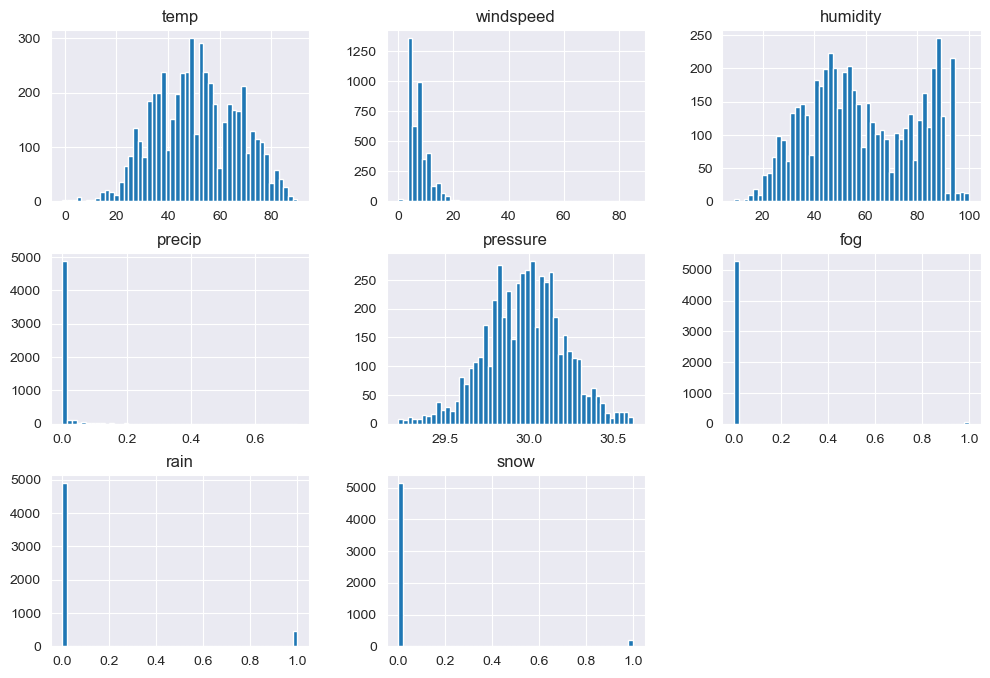

In [7]:
import matplotlib.pyplot as plt

weather_data_raw.hist(bins=50, figsize=(12, 8))
plt.show()

- timestamp into datetime
- temp into celsius
- windspeed into kph
- precip into mm
- pressure into hpa
- dailyprecip into mm
- dailysnow into mm

In [8]:
weather_data_raw.describe()

,temp,windspeed,humidity,precip,pressure,fog,rain,snow
count,5334.000000,4195.000000,5334.000000,5334.000000,5200.000000,5334.000000,5334.000000,5334.000000
mean,51.095726,7.388272,58.662917,0.007402,29.972810,0.008999,0.083802,0.037308
std,15.997815,3.982570,20.813630,0.035561,0.235095,0.094443,0.277117,0.189533
min,-0.900000,0.000000,9.000000,0.000000,29.220000,0.000000,0.000000,0.000000
25%,39.000000,4.600000,43.000000,0.000000,29.810000,0.000000,0.000000,0.000000
50%,51.100000,6.900000,56.000000,0.000000,29.980000,0.000000,0.000000,0.000000
75%,64.000000,9.200000,78.000000,0.000000,30.130000,0.000000,0.000000,0.000000
max,90.000000,85.200000,100.000000,0.730000,30.620000,1.000000,1.000000,1.000000


In [9]:
weather_data_raw.describe(include='object')

,timestamp,conditions,dailyprecip,dailysnow
count,5334,5334,5334,5334
unique,5329,23,41,11
top,2016-04-04 02:51:00,Clear,0.00,0.00
freq,2,2238,2577,4491


- Exactly one timestamp is duplicated: 2016-03-13 00:51:00; Two different entries (Clear vs. Light
Rain), probably two weather sources or measurements.

## EDA timestamp (datetime)

Add Weather Time Features
- timestamp -> datetime
- datetime_hour
- hour_of_day
- day_of_year
- hour_of_year

Drop
- day_of_year

In [10]:
weather_data = wf.add_weather_time_features(weather_data_raw)

Check for format consistency

In [11]:
weather_data['datetime_hour'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

Weather Observations per Hour

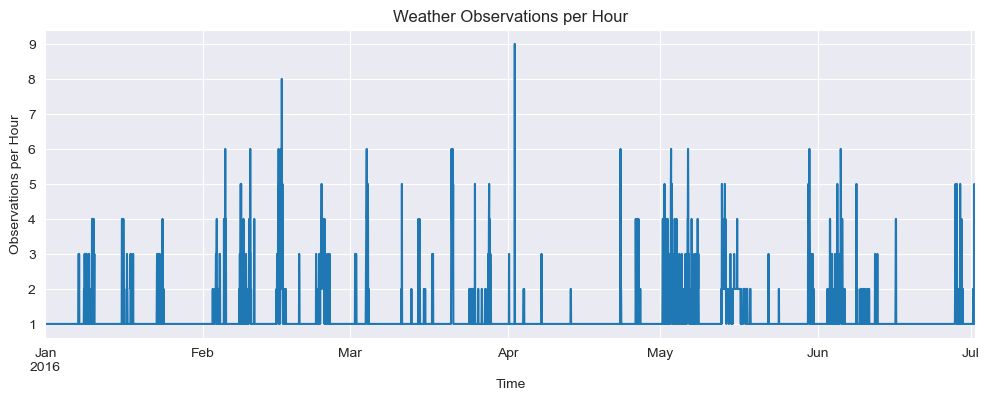

In [12]:
counts_per_hour = weather_data['datetime_hour'].value_counts().sort_index()

# Plot time series frequency
plt.figure(figsize=(12, 4))
counts_per_hour.plot()
plt.title("Weather Observations per Hour")
plt.xlabel("Time")
plt.ylabel("Observations per Hour")
plt.grid(True)
plt.show()

- The timestamps are predominantly distributed hourly, with slight fluctuations.
- There are some dips in frequency; potentially missing hours.
- The data does not appear to be exactly on the hour (e.g. xx:51).

Check how many records per minute/h

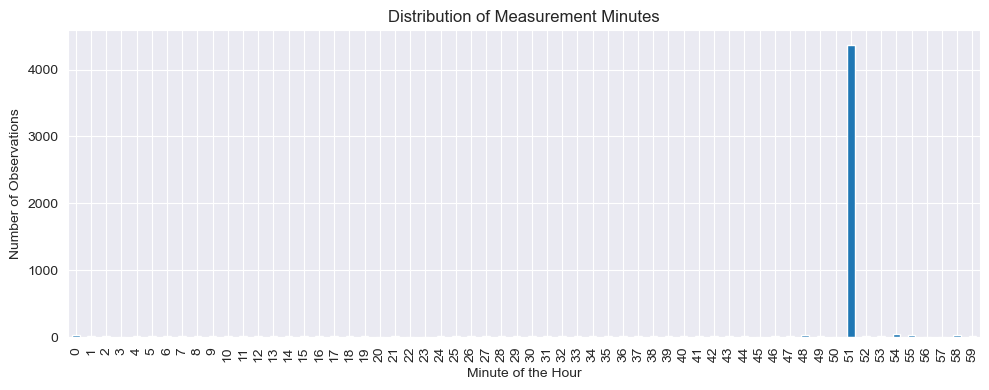

In [13]:
# Extract minute component from datetime
weather_data['datetime_minute'] = weather_data['datetime'].dt.minute

# Count how many records fall into each minute of the hour
minute_distribution = weather_data['datetime_minute'].value_counts().sort_index()

# Plot the distribution of measurement minutes
plt.figure(figsize=(10, 4))
minute_distribution.plot(kind='bar')
plt.title("Distribution of Measurement Minutes")
plt.xlabel("Minute of the Hour")
plt.ylabel("Number of Observations")
plt.grid(True)
plt.tight_layout()
plt.show()

- Minute 51 is by far the most frequent minute of measurement (over 4000 entries).
- All other minutes are rare or sporadic → probably exceptions, manual additions or other sources.

## Aggregate hourly records

In [14]:
# Aggregate to hourly level using mean for continuous values, max for binary flags
weather_data = wf.aggregate_weather_hourly(weather_data)

In [15]:
weather_data = wf.add_weather_time_features(weather_data, timestamp_col='datetime_hour')
weather_data = wf.clean_trace_and_convert(weather_data, ['dailyprecip'], 0.01)
weather_data = wf.clean_trace_and_convert(weather_data, ['dailysnow'], 0.1)

In [16]:
# Standardizes units of measurement
features.weather_features.add_metric_measurements(weather_data)

In [17]:
cols_to_drop = wc.WEATHER_COLUMNS_TO_DROP

weather_data.drop(columns=[col for col in wc.WEATHER_COLUMNS_TO_DROP if col in weather_data
                  .columns],
                  inplace=True)

## EDA temp

In [18]:
weather_data['temp_c'].describe()

count    4392.000000
mean       10.728907
std         9.158675
min       -18.277778
25%         3.888889
50%        10.611111
75%        17.777778
max        32.222222
Name: temp_c, dtype: float64

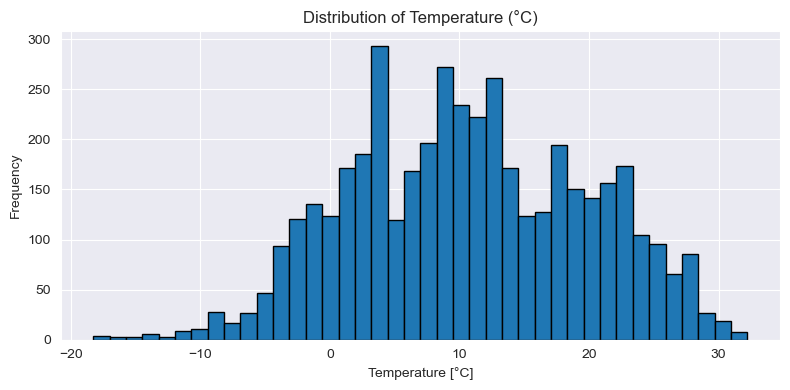

In [19]:
plt.figure(figsize=(8, 4))
weather_data['temp_c'].plot.hist(bins=40, edgecolor='black')
plt.title('Distribution of Temperature (°C)')
plt.xlabel("Temperature [°C]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

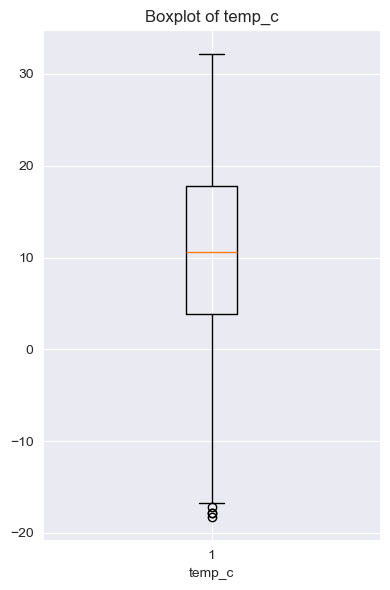

In [20]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["temp_c"].dropna())
plt.title("Boxplot of temp_c")
plt.xlabel("temp_c")
plt.tight_layout()
plt.show()

## EDA Windspeed

In [21]:
weather_data['windspeed_kph'].describe()

count    3542.000000
mean       11.689335
std         6.379921
min         0.000000
25%         7.402964
50%        11.104446
75%        14.805928
max       137.115768
Name: windspeed_kph, dtype: float64

In [22]:
weather_data['windspeed_kph'].isna().sum()

np.int64(850)

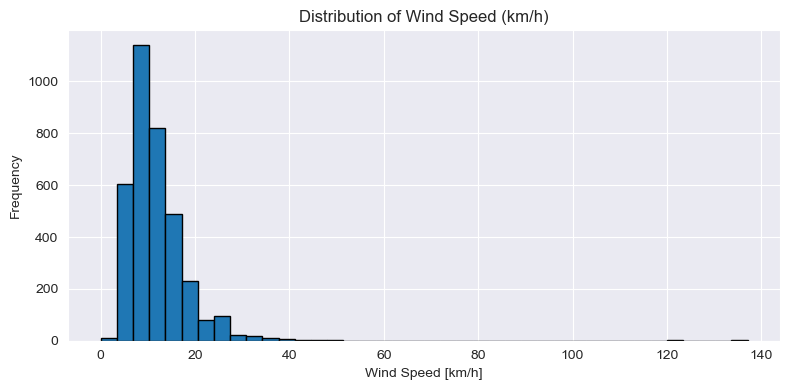

In [23]:
plt.figure(figsize=(8, 4))
weather_data['windspeed_kph'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Wind Speed (km/h)")
plt.xlabel("Wind Speed [km/h]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

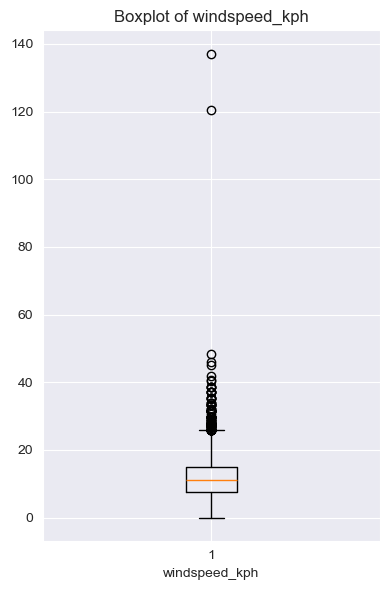

In [24]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["windspeed_kph"].dropna())
plt.title("Boxplot of windspeed_kph")
plt.xlabel("windspeed_kph")
plt.tight_layout()
plt.show()

- Most values lie between 5 and 25 km/h, which is typical for city-level weather.
- One extremely high value (137.12 km/h) may be an outlier.
- The variable appears well-behaved and usable without further transformation.

## EDA humidity

In [25]:
weather_data['humidity'].describe()

count    4392.000000
mean       54.144423
std        18.964341
min         9.000000
25%        40.000000
50%        51.000000
75%        67.125000
max       100.000000
Name: humidity, dtype: float64

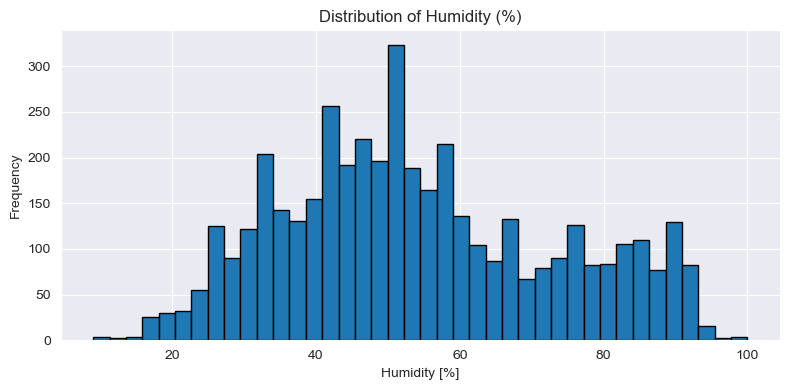

In [26]:
plt.figure(figsize=(8, 4))
weather_data['humidity'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Humidity (%)")
plt.xlabel("Humidity [%]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

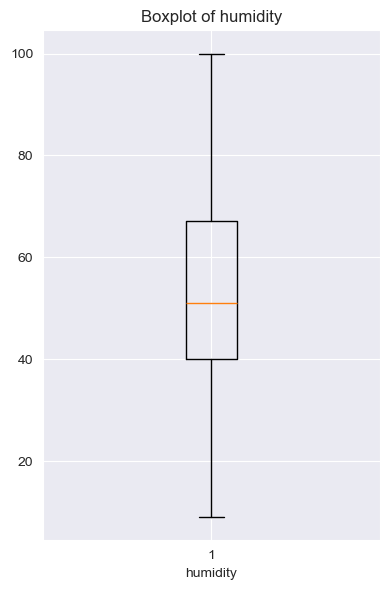

In [27]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["humidity"].dropna())
plt.title("Boxplot of humidity")
plt.xlabel("humidity")
plt.tight_layout()
plt.show()

- Values range from 9% to 97%.
- Most values lie between 40% and 70%.
- No anomalies or unrealistic entries.

## EDA precip

In [28]:
weather_data['precip_mm'].describe()

count    4392.000000
mean        0.228322
std         1.793477
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        46.990000
Name: precip_mm, dtype: float64

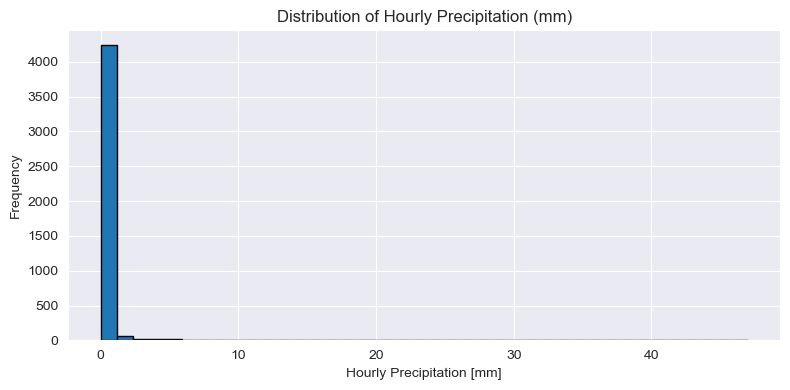

In [29]:
plt.figure(figsize=(8, 4))
weather_data['precip_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Hourly Precipitation (mm)")
plt.xlabel("Hourly Precipitation [mm]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

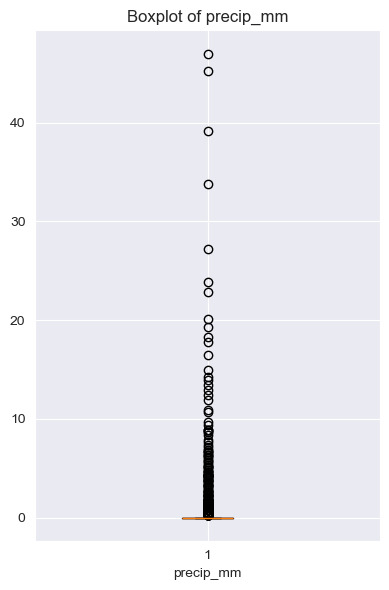

In [30]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["precip_mm"].dropna())
plt.title("Boxplot of precip_mm")
plt.xlabel("precip_mm")
plt.tight_layout()
plt.show()

Findings of the Exploration
- Most values are 0.0 (dry hours).
- Occasional rain events up to 18.5 mm.

Required Arrangements
- None. Consider binary flag creation (e.g. had_rain = precip_mm > 0).

## EDA pressure

In [31]:
weather_data['pressure_hPa'].describe()

count    4361.000000
mean     1015.640291
std         7.900185
min       989.841797
25%      1010.160137
50%      1015.917000
75%      1020.657946
max      1036.912618
Name: pressure_hPa, dtype: float64

In [32]:
weather_data['pressure_hPa'].isna().sum()

np.int64(31)

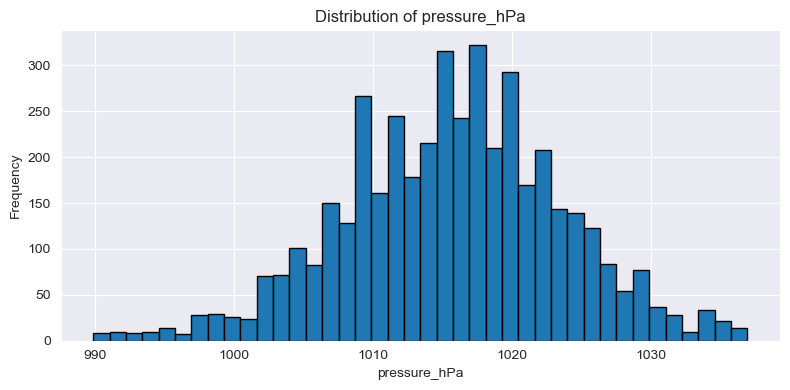

In [33]:
plt.figure(figsize=(8, 4))
weather_data['pressure_hPa'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

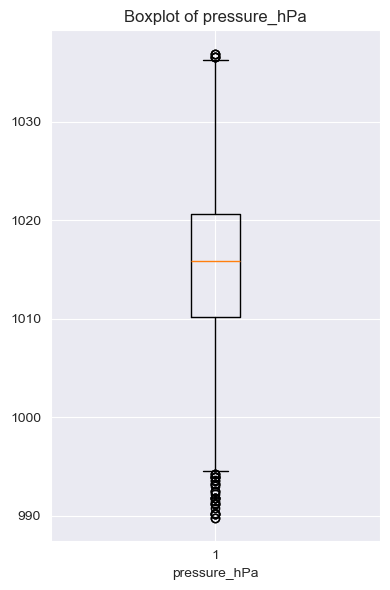

In [34]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["pressure_hPa"].dropna())
plt.title("Boxplot of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.tight_layout()
plt.show()

## EDA daily rain

In [35]:
weather_data['precip_daily_mm'].value_counts()

precip_daily_mm
0.000     2515
0.254      659
1.270       96
1.016       96
2.286       94
0.508       72
4.064       72
6.096       48
11.430      48
1.524       48
58.674      24
3.048       24
5.588       24
23.114      24
10.160      24
41.910      24
4.572       24
13.716      24
15.494      24
5.080       24
21.082      24
9.652       24
13.462      24
1.778       24
7.366       24
2.794       24
3.556       24
18.542      24
45.720      24
30.988      24
7.620       24
0.762       24
25.654      24
11.176      24
11.938      23
3.810       21
6.350       20
12.700       4
Name: count, dtype: int64

In [36]:
weather_data['precip_daily_mm'].isna().sum()

np.int64(0)

In [37]:
weather_data['precip_daily_mm'].describe()

count    4392.000000
mean        2.626112
std         7.667371
min         0.000000
25%         0.000000
50%         0.000000
75%         1.016000
max        58.674000
Name: precip_daily_mm, dtype: float64

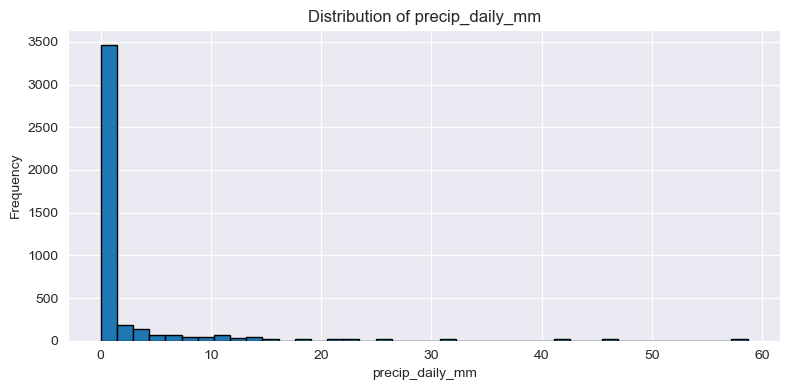

In [38]:
plt.figure(figsize=(8, 4))
weather_data['precip_daily_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

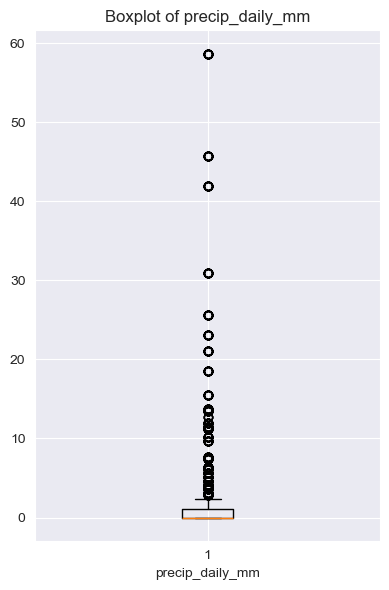

In [39]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["precip_daily_mm"].dropna())
plt.title("Boxplot of precip_daily_mm")
plt.xlabel("precip_daily_mm")
plt.tight_layout()
plt.show()

- ...

## EDA dailysnow

In [40]:
weather_data['daily_snow_mm'].value_counts()

daily_snow_mm
0.00      3915
2.54       309
10.16       48
5.08        24
675.64      24
63.50       24
35.56       24
12.70       24
Name: count, dtype: int64

In [41]:
weather_data['daily_snow_mm'].describe()

count    4392.000000
mean        4.620232
std        50.052473
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       675.640000
Name: daily_snow_mm, dtype: float64

In [42]:
weather_data['daily_snow_mm'].isna().sum()

np.int64(0)

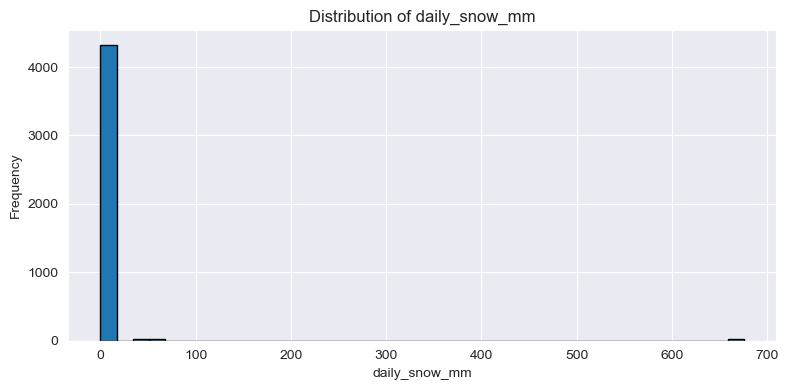

In [43]:
plt.figure(figsize=(8, 4))
weather_data['daily_snow_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of daily_snow_mm")
plt.xlabel("daily_snow_mm")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

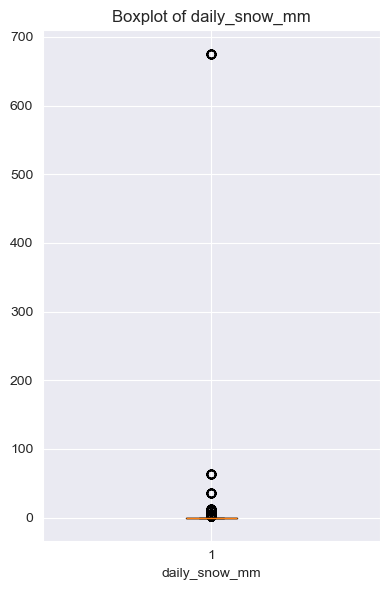

In [44]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data["daily_snow_mm"].dropna())
plt.title("Boxplot of daily_snow_mm")
plt.xlabel("daily_snow_mm")
plt.tight_layout()
plt.show()

EDA fog, rain, snow

In [45]:
weather_data['fog'].value_counts()

fog
0    4361
1      31
Name: count, dtype: int64

In [46]:
weather_data['rain'].value_counts()

rain
0    4169
1     223
Name: count, dtype: int64

In [47]:
weather_data['snow'].value_counts()

snow
0    4313
1      79
Name: count, dtype: int64

## EDA Conditions

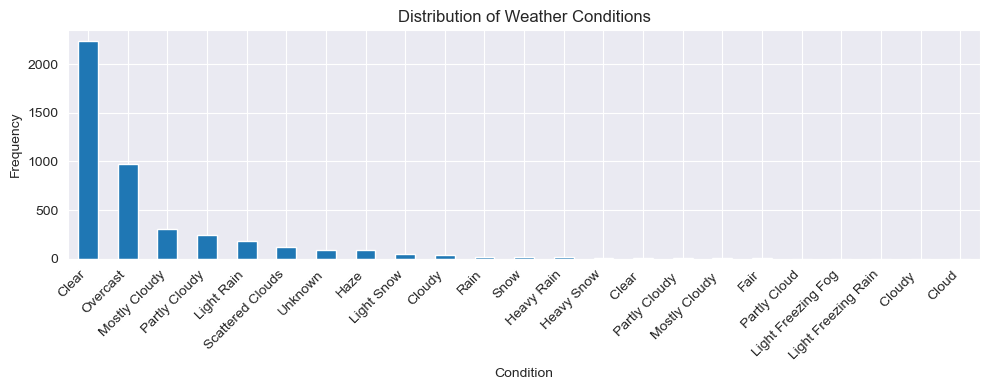

In [48]:
condition_counts = weather_data['conditions'].value_counts()

plt.figure(figsize=(10, 4))
condition_counts.plot(kind='bar')
plt.title("Distribution of Weather Conditions")
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

- Most common condition is Clear (2215 times), followed by Overcast (1000).
- Some conditions occur only a few times, e.g., Heavy Snow, Light Freezing Fog.
- Unknown appears 83 times and may indicate missing or invalid sensor data.

# Save to csv

In [50]:
import os

# Ensure the directory exists
output_dir = os.path.dirname(config.WEATHER_DATA_DIR)
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to CSV
weather_data.to_csv(config.WEATHER_DATA_SAVE, index=True)

In [51]:
weather_data

,datetime_hour,humidity,fog,rain,snow,conditions,datetime,hour_of_day,hour_of_year,temp_c,windspeed_kph,precip_mm,pressure_hPa,precip_daily_mm,daily_snow_mm
0,2016-01-01 00:00:00,51.0,0,0,0,Overcast,2016-01-01 00:00:00,0,0,5.611111,7.402964,0.000,1017.948834,0.000,0.0
1,2016-01-01 01:00:00,53.0,0,0,0,Overcast,2016-01-01 01:00:00,1,1,5.000000,5.632690,0.000,1017.948834,0.000,0.0
2,2016-01-01 02:00:00,55.0,0,0,0,Overcast,2016-01-01 02:00:00,2,2,5.000000,7.402964,0.000,1017.948834,0.000,0.0
3,2016-01-01 03:00:00,55.0,0,0,0,Overcast,2016-01-01 03:00:00,3,3,5.000000,14.805928,0.000,1017.948834,0.000,0.0
4,2016-01-01 04:00:00,58.0,0,0,0,Overcast,2016-01-01 04:00:00,4,4,4.388889,16.737136,0.000,1017.271556,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,2016-07-01 19:00:00,90.0,0,0,0,Clear,2016-07-01 19:00:00,19,4387,21.722222,7.402964,0.000,1011.853332,21.082,0.0
4388,2016-07-01 20:00:00,93.0,0,0,0,Partly Cloudy,2016-07-01 20:00:00,20,4388,21.111111,NaN,0.000,1011.176054,21.082,0.0
4389,2016-07-01 21:00:00,90.0,0,0,0,Mostly Cloudy,2016-07-01 21:00:00,21,4389,20.861111,11.184913,0.000,1012.530610,21.082,0.0
4390,2016-07-01 22:00:00,93.0,0,1,0,Light Rain,2016-07-01 22:00:00,22,4390,19.411111,5.632690,45.212,1012.733793,21.082,0.0
